In [1]:
import os
from datetime import datetime

host = os.uname()[1]
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"{host}, ", dt_string)

blackwell,  08/01/2022 12:50:07


In [2]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as drv
import pycuda.gpuarray as gpuarray
import skcuda.cublas as cublas

import cuda_util

print()
print(f'{pycuda.VERSION_TEXT=}')
print(f'{drv.get_version()=}')
print(f'{drv.get_driver_version()=}')
print()

dev_id = 1

seed = 1234
np.random.seed(seed)
    
ctx = drv.Device(dev_id).make_context()
dev = drv.Context.get_device()
cuda_util.query_dev(drv, dev_id)

libcublas.so
<CDLL '/home/krocki/nv/cuBLAS/build/src/libcublas.so', handle 3a09710 at 0x7fa5596601c0>
<CDLL '/home/krocki/nv/cuBLAS/build/src/libcublas.so', handle 3a09710 at 0x7fa5596601c0>
11901

pycuda.VERSION_TEXT='2021.1'
drv.get_version()=(11, 5, 0)
drv.get_driver_version()=11050

Device #1: NVIDIA A100-SXM-80GB
  Arch: 8.0, Mem: 81251 MB, 2039 GBps
  108 SMs, 6912 cores, 40.0 MB L2, 1.41 GHz
     TF/s:      9.75 FP64     19.49 FP32     77.97 FP16
  TC TF/s:     19.49 FP64    155.93 FP32    311.87 FP16



In [3]:
def mmul(handle, M, N, K, repeat, dtype, init='ones'):

    if init == 'randn':
        A = np.array(np.random.randn(M, K), dtype=dtype, order='F').astype(dtype)
        B = np.array(np.random.randn(K, N), dtype=dtype, order='F').astype(dtype)

    if init == 'rand':
        A = np.array(np.random.rand(M, K), dtype=dtype, order='F').astype(dtype)
        B = np.array(np.random.rand(K, N), dtype=dtype, order='F').astype(dtype)
        
    elif init == 'zeros':
        A = np.array(np.zeros((M, K), dtype=dtype, order='F')).astype(dtype)
        B = np.array(np.zeros((K, N), dtype=dtype, order='F')).astype(dtype)

    elif init == '025':
        A = np.array(np.zeros((M, K), dtype=dtype, order='F') + 0.25).astype(dtype)
        B = np.array(np.zeros((K, N), dtype=dtype, order='F') + 0.25).astype(dtype)

    elif init == '16':
        A = np.array(np.zeros((M, K), dtype=dtype, order='F') + 16).astype(dtype)
        B = np.array(np.zeros((K, N), dtype=dtype, order='F') + 16).astype(dtype)
        
    elif init == 'ones':
        A = np.array(np.ones((M, K), dtype=dtype, order='F')).astype(dtype)
        B = np.array(np.ones((K, N), dtype=dtype, order='F')).astype(dtype)
 
    elif init == 'sparse01':
        A = np.array(np.random.rand(M, K), dtype=dtype, order='F').astype(dtype)
        B = np.array(np.random.rand(K, N), dtype=dtype, order='F').astype(dtype)
        A[A>0.001] = 0
        B[B>0.001] = 0
        
    elif init == 'sparse02':
        A = np.array(np.random.rand(M, K), dtype=dtype, order='F').astype(dtype)
        B = np.array(np.random.rand(K, N), dtype=dtype, order='F').astype(dtype)
        A[A>0.01] = 0
        B[B>0.01] = 0

    elif init == 'sparse05':
        A = np.array(np.random.rand(M, K), dtype=dtype, order='F').astype(dtype)
        B = np.array(np.random.rand(K, N), dtype=dtype, order='F').astype(dtype)
        A[A>0.5] = 0
        B[B>0.5] = 0
        
    else:
        A = np.array(np.random.rand(M, K), dtype=dtype, order='F').astype(dtype)
        B = np.array(np.random.rand(K, N), dtype=dtype, order='F').astype(dtype)
        
    #A = np.ones((M, K), dtype=dtype, order='F')
    #B = np.ones((K, N), dtype=dtype, order='F')
    
    #A = np.zeros((M, K), dtype=dtype, order='F')
    #B = np.zeros((K, N), dtype=dtype, order='F')
    
    d_A = gpuarray.to_gpu(A)
    d_B = gpuarray.to_gpu(B)

    m, k = d_A.shape
    k, n = d_B.shape

    d_C = gpuarray.empty((m, n), dtype=dtype, order='F')

    alpha = dtype(1)
    beta  = dtype(0)
    
    start = drv.Event()
    end   = drv.Event()

    # cublas<T>gemm(handle,
    # transa, transb, m, n, k, alpha,
    # A, lda,
    # B, ldb, beta,
    # C, ldc)
    
    xgemm = {
        np.float32: cublas.cublasSgemm,
        np.float64: cublas.cublasDgemm
    }
    
    gemm_gflop = 1e-9 * m * n * k * 2
    
    start.record()
    for i in range(repeat):
        xgemm[dtype](handle,
                     transa='n', transb='n',
                     m=m, n=n, k=k, alpha=alpha,
                     A=d_A.ptr, lda=m,
                     B=d_B.ptr, ldb=k, beta=beta,
                     C=d_C.ptr, ldc=m)
        
    end.record()
    end.synchronize()
    gemm_time = end.time_since(start) / (repeat * 1e3)

    d_C = d_C.reshape(d_C.shape, order = 'F')

    C = np.dot(A, B).astype(dtype)

    err = np.linalg.norm(d_C.get() - C)

    gflop_per_sec = gemm_gflop/gemm_time
    
    print(f'{err=:12g}, {m=:5}, {n=:5}, {k=:5}'
          f', time={gemm_time:.4f} ms'
          f', {gflop_per_sec:10.3f} GF/s')
    
    return gflop_per_sec

In [4]:
"""
test tensor core math
"""

import ctypes

"""
/*Enum for default math mode/tensor operation*/
typedef enum {
  CUBLAS_DEFAULT_MATH = 0,

  /* deprecated, same effect as using CUBLAS_COMPUTE_32F_FAST_16F, will be removed in a future release */
  CUBLAS_TENSOR_OP_MATH = 1,

  /* same as using matching _PEDANTIC compute type when using cublas<T>routine calls or cublasEx() calls with
     cudaDataType as compute type */
  CUBLAS_PEDANTIC_MATH = 2,

  /* allow accelerating single precision routines using TF32 tensor cores */
  CUBLAS_TF32_TENSOR_OP_MATH = 3,

  /* flag to force any reductons to use the accumulator type and not output type in case of mixed precision routines
     with lower size output type */
  CUBLAS_MATH_DISALLOW_REDUCED_PRECISION_REDUCTION = 16,
} cublasMath_t;

typedef enum {
  CUBLAS_COMPUTE_16F = 64,           /* half - default */
  CUBLAS_COMPUTE_16F_PEDANTIC = 65,  /* half - pedantic */
  CUBLAS_COMPUTE_32F = 68,           /* float - default */
  CUBLAS_COMPUTE_32F_PEDANTIC = 69,  /* float - pedantic */
  CUBLAS_COMPUTE_32F_FAST_16F = 74,  /* float - fast, allows down-converting inputs to half or TF32 */
  CUBLAS_COMPUTE_32F_FAST_16BF = 75, /* float - fast, allows down-converting inputs to bfloat16 or TF32 */
  CUBLAS_COMPUTE_32F_FAST_TF32 = 77, /* float - fast, allows down-converting inputs to TF32 */
  CUBLAS_COMPUTE_64F = 70,           /* double - default */
  CUBLAS_COMPUTE_64F_PEDANTIC = 71,  /* double - pedantic */
  CUBLAS_COMPUTE_32I = 72,           /* signed 32-bit int - default */
  CUBLAS_COMPUTE_32I_PEDANTIC = 73,  /* signed 32-bit int - pedantic */
} cublasComputeType_t;

"""
CUBLAS_MATH_MODE = {
    'CUBLAS_DEFAULT_MATH': 0,
    'CUBLAS_TENSOR_OP_MATH': 1,
    'CUBLAS_PEDANTIC_MATH': 2,
    'CUBLAS_TF32_TENSOR_OP_MATH': 3,
    'CUBLAS_MATH_DISALLOW_REDUCED_PRECISION_REDUCTION': 16
}

"""
cublasStatus_t cublasSetMathMode(cublasHandle_t handle, cublasMath_t mode)
"""
def cublasSetMathMode(handle, lib, mode):
    status = lib._libcublas.cublasSetMathMode(handle, mode)
    lib.cublasCheckStatus(status)

"""
cublasStatus_t cublasGetMathMode(cublasHandle_t handle, cublasMath_t *mode)
"""
def cublasGetMathMode(handle, lib):
    mode = ctypes.c_int()
    status = lib._libcublas.cublasGetMathMode(handle, ctypes.byref(mode))
    lib.cublasCheckStatus(status)
    return mode.value

"""
cublasStatus_t cublasLoggerConfigure(
    int             logIsOn,
    int             logToStdOut,
    int             logToStdErr,
    const char*     logFileName)
"""
def cublasLoggerConfigure(lib, logIsOn, logToStdOut, logToStdErr, logFileName):
    status = lib._libcublas.cublasGetMathMode(logIsOn, logToStdOut, logToStdErr, logFileName)
    lib.cublasCheckStatus(status)

In [5]:
results = {}
# square
sizes = [64, 128, 256, 384, 512, 768, 1024, 1536, 2048, 3072, 4096]
precisions = [np.float64, np.float32]
cublas_modes = [
             'CUBLAS_DEFAULT_MATH',
             'CUBLAS_TENSOR_OP_MATH',
             'CUBLAS_PEDANTIC_MATH',
             'CUBLAS_TF32_TENSOR_OP_MATH',
             'CUBLAS_MATH_DISALLOW_REDUCED_PRECISION_REDUCTION']

In [6]:
for dpattern in ['zeros', 'ones', '025', '16', 'randn', 'rand', 'sparse01', 'sparse02', 'sparse05']:
    results[dpattern] = {}
    
    for dtype in precisions:
        results[dpattern][dtype] = {}
        
        for mode in cublas_modes:

            handle = cublas.cublasCreate()
            cublasSetMathMode(handle, cublas, CUBLAS_MATH_MODE[mode])
            print(f'\n{dpattern=}, {dtype=}, {mode=}\n-----------')

            results[dpattern][dtype][mode] = []
            for i in sizes:
                M = N = K = i
                flops = mmul(handle, M, N, K, repeat=10, dtype=dtype, init=dpattern)
                results[dpattern][dtype][mode].append(flops)

            cublas.cublasDestroy(handle)


dpattern='zeros', dtype=<class 'numpy.float64'>, mode='CUBLAS_DEFAULT_MATH'
-----------
err=           0, m=   64, n=   64, k=   64, time=0.0000 ms,     12.162 GF/s
err=           0, m=  128, n=  128, k=  128, time=0.0000 ms,    348.688 GF/s
err=           0, m=  256, n=  256, k=  256, time=0.0000 ms,   1312.853 GF/s
err=           0, m=  384, n=  384, k=  384, time=0.0000 ms,   3827.126 GF/s
err=           0, m=  512, n=  512, k=  512, time=0.0000 ms,   8802.317 GF/s
err=           0, m=  768, n=  768, k=  768, time=0.0001 ms,  12924.109 GF/s
err=           0, m= 1024, n= 1024, k= 1024, time=0.0001 ms,  15649.658 GF/s
err=           0, m= 1536, n= 1536, k= 1536, time=0.0004 ms,  17173.869 GF/s
err=           0, m= 2048, n= 2048, k= 2048, time=0.0010 ms,  17778.831 GF/s
err=           0, m= 3072, n= 3072, k= 3072, time=0.0031 ms,  18542.041 GF/s
err=           0, m= 4096, n= 4096, k= 4096, time=0.0072 ms,  19169.195 GF/s

dpattern='zeros', dtype=<class 'numpy.float64'>, mode='CUBLAS_T

zeros
y_pos=19162.073950413265
rand
y_pos=16957.190218151976
sparse05
y_pos=17660.519176773916
zeros
y_pos=169950.4836552402
rand
y_pos=149717.230347885
sparse05
y_pos=154174.16895346317


Text(0.5, 0.98, 'Matmul GF/s vs size\n')

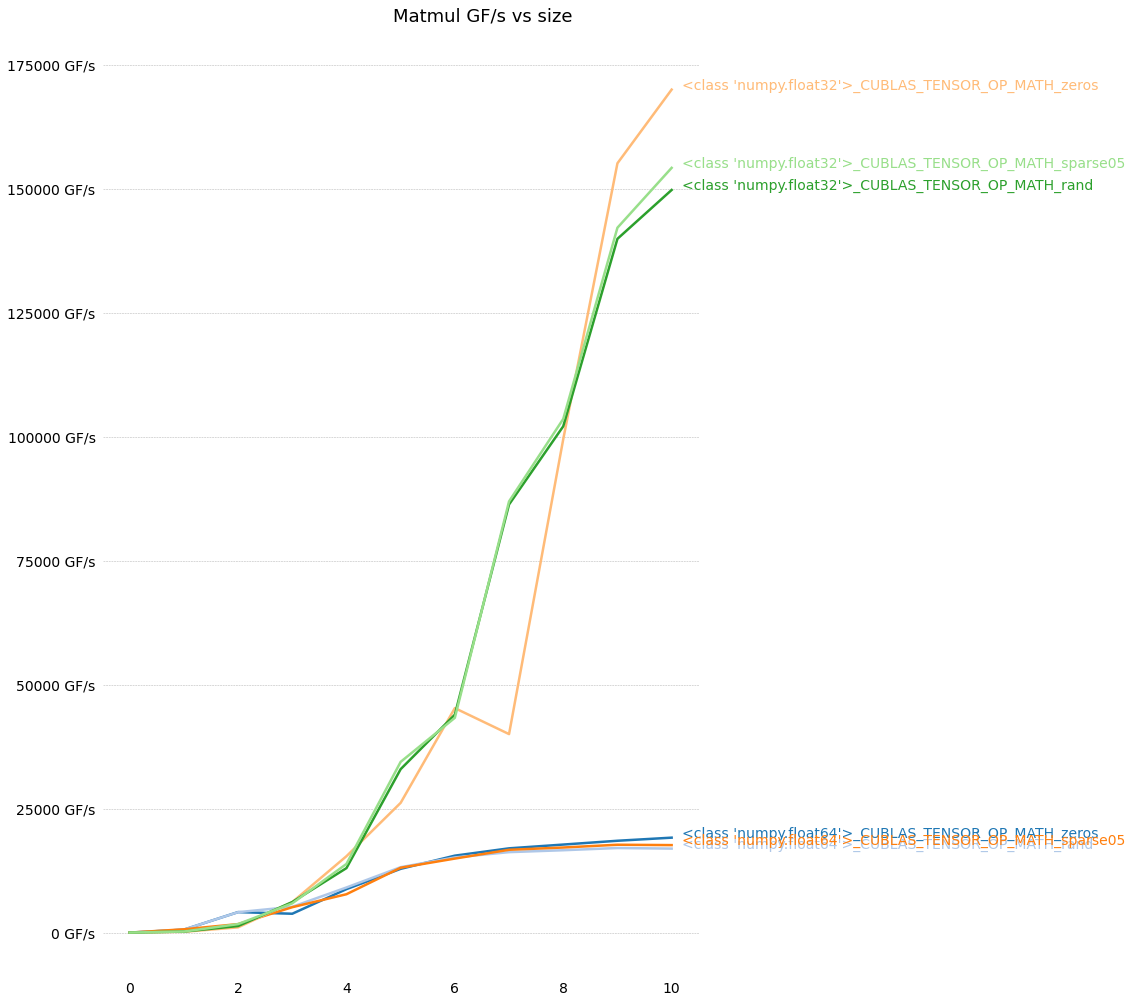

In [78]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 14))
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
# Ticks on the right and top of the plot are generally unnecessary.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)

# Limit the range of the plot to only where the data is.
# Avoid unnecessary whitespace.
#ax.set_xlim(1969.5, 2011.1)
#ax.set_ylim(-0.25, 90)
# Set a fixed location and format for ticks.
#ax.set_xticks(range(1970, 2011, 10))
#ax.set_yticks(range(0, 91, 10))
ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}'.format))
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f} GF/s'.format))
ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

ax.tick_params(axis='both', which='both', labelsize=14,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)

pattern = ['zeros', 'rand', 'sparse05']
mode = ['CUBLAS_TENSOR_OP_MATH']
prec = [np.float64, np.float32]

#ax.set_xlim(5, 10)
#ax.set_ylim(15000, 20000)

for fp in prec:
    for m in mode:
        for p in pattern:   
            p_name = p.replace('\n', '_').replace(' ', '_')
            print(p_name)
            dat = results[p][fp][m]
            line, = ax.plot(dat, lw=2.5)
            y_pos = dat[-1] - 0.5
            print(f'{y_pos=}')
            ax.text(10.2, y_pos, f'{fp}_{m}_{p}', fontsize=14, color=line.get_color())

fig.suptitle('Matmul GF/s vs size\n', fontsize=18, ha='center')